# Python `operator` library

See Python's built-in [`operator`](https://docs.python.org/3/library/operator.html) library

## What we have now

Build test model

In [ ]:
import expertsystem as es

result = es.generate_transitions(
    initial_state=[("J/psi(1S)", [-1, 1])],
    final_state=["p", "p~", "eta"],
    allowed_intermediate_particles=["N(1440)"],
    allowed_interaction_types="strong",
)
model = es.generate_amplitudes(result)
for particle in result.get_intermediate_particles():
    model.dynamics.set_breit_wigner(particle.name)
es.io.write(model, "recipe.yml")

Propagating quantum numbers: 100%|██████████| 24/24 [00:00<00:00, 102.35it/s]


Visualize the decay:

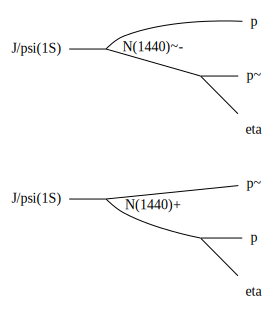

In [ ]:
import graphviz

graphs = result.collapse_graphs()
dot = es.io.asdot(graphs)
graphviz.Source(dot)

In [ ]:
model.parameters

FitParameters([
    FitParameter(name='Magnitude_J/psi(1S)_to_N(1440)+_0.5+p~_-0.5;N(1440)+_to_eta_0+p_0.5;', value=1.0, fix=False),
    FitParameter(name='Magnitude_J/psi(1S)_to_N(1440)+_0.5+p~_0.5;N(1440)+_to_eta_0+p_0.5;', value=1.0, fix=False),
    FitParameter(name='Magnitude_J/psi(1S)_to_N(1440)~-_0.5+p_-0.5;N(1440)~-_to_eta_0+p~_0.5;', value=1.0, fix=False),
    FitParameter(name='Magnitude_J/psi(1S)_to_N(1440)~-_0.5+p_0.5;N(1440)~-_to_eta_0+p~_0.5;', value=1.0, fix=False),
    FitParameter(name='MesonRadius_J/psi(1S)', value=1.0, fix=True),
    FitParameter(name='MesonRadius_N(1440)+', value=1.0, fix=True),
    FitParameter(name='MesonRadius_N(1440)~-', value=1.0, fix=True),
    FitParameter(name='Phase_J/psi(1S)_to_N(1440)+_0.5+p~_-0.5;N(1440)+_to_eta_0+p_0.5;', value=0.0, fix=False),
    FitParameter(name='Phase_J/psi(1S)_to_N(1440)+_0.5+p~_0.5;N(1440)+_to_eta_0+p_0.5;', value=0.0, fix=False),
    FitParameter(name='Phase_J/psi(1S)_to_N(1440)~-_0.5+p_-0.5;N(1440)~-_to_eta_0+p

## Implementation with `operators`

See [this answer](https://stackoverflow.com/a/7844038) on Stack Overflow:

In [ ]:
import operator

MAKE_BINARY = lambda opfn: lambda self, other: BinaryOp(  # noqa: E731
    self, asMagicNumber(other), opfn
)
MAKE_RBINARY = lambda opfn: lambda self, other: BinaryOp(  # noqa: E731
    asMagicNumber(other), self, opfn
)


class MagicNumber(object):
    __add__ = MAKE_BINARY(operator.add)
    __sub__ = MAKE_BINARY(operator.sub)
    __mul__ = MAKE_BINARY(operator.mul)
    __radd__ = MAKE_RBINARY(operator.add)
    __rsub__ = MAKE_RBINARY(operator.sub)
    __rmul__ = MAKE_RBINARY(operator.mul)
    # __div__  = MAKE_BINARY(operator.div)
    # __rdiv__ = MAKE_RBINARY(operator.div)
    __truediv__ = MAKE_BINARY(operator.truediv)
    __rtruediv__ = MAKE_RBINARY(operator.truediv)
    __floordiv__ = MAKE_BINARY(operator.floordiv)
    __rfloordiv__ = MAKE_RBINARY(operator.floordiv)

    def __neg__(self, other):
        return UnaryOp(self, lambda x: -x)

    @property
    def value(self):
        return self.eval()


class Constant(MagicNumber):
    def __init__(self, value):
        self.value_ = value

    def eval(self):
        return self.value_


class Parameter(Constant):
    def __init__(self):
        super(Parameter, self).__init__(0.0)

    def setValue(self, v):
        self.value_ = v

    value = property(fset=setValue, fget=lambda self: self.value_)


class BinaryOp(MagicNumber):
    def __init__(self, op1, op2, operation):
        self.op1 = op1
        self.op2 = op2
        self.opn = operation

    def eval(self):
        return self.opn(self.op1.eval(), self.op2.eval())


class UnaryOp(MagicNumber):
    def __init__(self, op1, operation):
        self.op1 = op1
        self.operation = operation

    def eval(self):
        return self.opn(self.op1.eval())


asMagicNumber = (
    lambda x: x if isinstance(x, MagicNumber) else Constant(x)  # noqa: E731
)
asMagicNumber(2).eval()

2

## Other ideas

````{dropdown} Option 1: parameter _container_
Remove `name` from the `FitParameter` class and give the `FitParameters` collection class the responsibility to keep track of 'names' of the `FitParameter`s as keys in a `dict`. In the `AmplitudeModel`, locations where a `FitParameter` should be inserted are indicated by an immutable (!) `str` that should exist as a key in the `FitParameters`.

Such a setup best reflects the structure of the `AmplitudeModel` that we have now (best illustrated by [`expected_recipe`](https://github.com/ComPWA/expertsystem/blob/f4f1c553780e263eb5b2a478951223694386f22a/tests/unit/io/expected_recipe.yml), note in particular YAML anchors like [`&par1`](https://github.com/ComPWA/expertsystem/blob/f4f1c553780e263eb5b2a478951223694386f22a/tests/unit/io/expected_recipe.yml#L11)/[`*par1`](https://github.com/ComPWA/expertsystem/blob/f4f1c553780e263eb5b2a478951223694386f22a/tests/unit/io/expected_recipe.yml#L59)). It also allows one to couple `FitParameters`. See following snippet:

```{literalinclude} ./parameter_container.py

```
````

````{dropdown} Option 2: read-only parameter _manager_
Remove the `FitParameters` collection class altogether and use something like immutable `InitialParameter` instances in the dynamics and intensity section of the `AmplitudeModel`. The `AmplitudeModel` then starts to serve as a read-only' template. A fitter package like `tensorwaves` can then loop over the `AmplitudeModel` structure to extract the `InitialParameter` instances and convert them to something like an `FitParameter`.

Here's a rough sketch with `tensorwaves` in mind.
```python
from typing import Dict, Generator, List

import attr

from expertsystem.amplitude.model import (
    AmplitudeModel,
    Dynamics,
    Node,
    ParticleDynamics,
)
from expertsystem.particle import Particle


@attr.s
class InitialParameter:
    name: str = attr.ib()
    value: float = attr.ib()
    # fix: bool = attr.ib(default=False)


@attr.s
class FitParameter:
    name: str = attr.ib(on_setattr=attr.setters.frozen)
    value: float = attr.ib()
    fix: bool = attr.ib(default=False)


class FitParameterManager:
    """Manages all fit parameters of the model"""

    def __init__(self, model: AmplitudeModel) -> None:
        self.__model: AmplitudeModel
        self.__parameter_couplings: Dict[str, str]

    @property
    def parameters(self) -> List[FitParameter]:
        initial_parameters = list(__yield_parameter(self.__model))
        self.__apply_couplings()
        return self.__convert(initial_parameters)

    def couple_parameters(self, parameter1: str, parameter2: str) -> None:
        pass

    def __convert(self, params: List[InitialParameter]) -> List[FitParameter]:
        pass


@attr.s
class CustomDynamics(Dynamics):
    parameter: InitialParameter = attr.ib(kw_only=True)

    @staticmethod
    def from_particle(particle: Particle):
        pass


def __yield_parameter(
    instance: object,
) -> Generator[InitialParameter, None, None]:
    if isinstance(instance, InitialParameter):
        yield instance
    elif isinstance(instance, (ParticleDynamics, Node)):
        for item in instance.values():
            yield from __yield_parameter(item)
    elif isinstance(instance, (list,)):
        for item in instance:
            yield from __yield_parameter(item)
    elif attr.has(instance.__class__):
        for field in attr.fields(instance.__class__):
            field_value = getattr(instance, field.name)
            yield from __yield_parameter(field_value)


# usage in tensorwaves
amp_model = AmplitudeModel()
kinematics: HelicityKinematics = ...
builder = IntensityBuilder(kinematics)

intensity = builder.create(amp_model)  # this would call amp_model.parameters
parameters: Dict[str, float] = intensity.parameters
# PROBLEM?: fix status is lost at this point

data_sample = generate_data(...)
dataset = kinematics.convert(data_sample)

parameters["Width_f(0)(980)"] = 0.2  # name is immutable at this point

# name of a parameter can be changed in the AmplitudeModel though
# and then call builder again
intensity(dataset, parameters)
```
````